In [241]:
import torch
import torchvision
import torchvision.transforms as transforms
from model.resnet import ResNet18
from model.resnext import CifarResNeXt
from model.wrn import WideResNet
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from torchsummary import summary

#### Loading student and teacher models

In [242]:
resnet18 = ResNet18() # student model
resnext = CifarResNeXt(cardinality=8, depth=29, num_classes=10)

wrn = WideResNet(depth=28, num_classes=10, widen_factor=10, dropRate=0.3)

resnet18.load_state_dict(torch.load('./experiments/resnet18_distill/resnext_teacher/best.pth.tar', map_location='cpu')['state_dict'])


state_dict = torch.load('./experiments/base_wrn/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
wrn.load_state_dict(new_state_dict)


state_dict = torch.load('./experiments/base_resnext29/best.pth.tar', map_location='cpu')['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
# load params
resnext.load_state_dict(new_state_dict)

<All keys matched successfully>

In [243]:
train_transformer = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
        ])

trainset = torchvision.datasets.CIFAR10(root='./data-cifar10', train=True, download=True, transform=train_transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

Files already downloaded and verified


torch.Size([32, 3, 32, 32]) tensor([2, 9, 1, 8, 3, 7, 8, 8, 7, 2, 1, 3, 5, 6, 3, 1, 6, 1, 2, 4, 5, 6, 7, 3,
        3, 0, 7, 9, 6, 4, 7, 8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


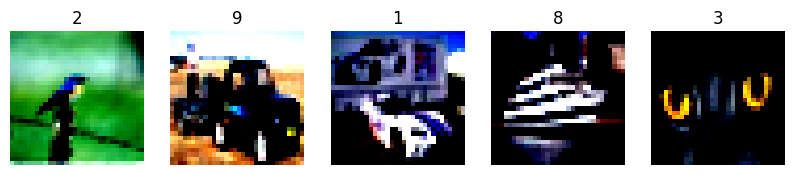

In [244]:
sample_train_batch, smaple_labels_batch = next(iter(trainloader))
print(sample_train_batch.shape, smaple_labels_batch)
fig, ax = plt.subplots(1, 5, figsize=(10, 10))
for i in range(5):
    ax[i].imshow(sample_train_batch[i].numpy().transpose(1, 2, 0))
    ax[i].set_title(smaple_labels_batch[i].item())
    ax[i].axis('off')

In [245]:
# for name, param in wrn.named_parameters():
#     print(name, param.shape)

# import torchvision.models as models
# model = models.resnet50(pretrained=True)
# # print(model.layer4)

# for name, param in model.named_parameters():
#     print(name, param.shape)

#### Registering the forward hooks

In [246]:
# register forward hook before the average pooling layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# adding forward hook to the penultimate relu layer to the student and teacher model
resnet18.layer4[1].shortcut.register_forward_hook(get_activation('shortcut'))
wrn.relu.register_forward_hook(get_activation('relu'))

#### Utility functions

In [247]:
# these are the weights we will use for class activation mapping
def get_fc_params(model, name):
    fc_params = torch.tensor([])
    for n, param in model.named_parameters():
        if n == name:
            fc_params = param
            print(n, param.shape)
    return fc_params

In [248]:
def get_weighted_CAM(forward_hooked_model, input, weights, student = True, rescale=True):
    if student:
        key = 'shortcut'
        layer_size = 512
        resize_val = 4
    else:
        key = 'relu'
        layer_size = 640
        resize_val = 8
    predictions = forward_hooked_model(input) # torch.unsqueeze(train_batch[index], 0)
    activation[key] = activation[key][0]
    activation[key] = activation[key].permute(1, 2, 0)
    activation[key] = activation[key].reshape(-1, layer_size)

    activation_map = torch.matmul(activation[key], weights)
    activation_map = activation_map.reshape(resize_val, resize_val)
    
    if rescale:
        activation_map = activation_map - torch.min(activation_map)
        activation_map = activation_map / (torch.max(activation_map) - torch.min(activation_map))
        activation_map = activation_map * 255

    return activation_map, predictions

#### Teacher model

In [249]:
fc_params_teacher = get_fc_params(wrn, 'fc.weight')

# train_iter = iter(trainloader)
# current_input_batch = next(train_iter)[0]
# current_label_batch = next(train_iter)[1]
# print(current_input_batch.shape, current_label_batch.shape)

# train_transformer_2 = transforms.Compose([
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
# ])

# complexity_values = []

# for i in range(current_input_batch.shape[0]):
#     activation_map, predictions = get_weighted_CAM(wrn, torch.unsqueeze(current_input_batch[i], 0), fc_params_teacher[current_label_batch[i]], student=False)
#     activation_map = activation_map.detach().numpy() # CAMc(x)

#     complexity_values.append(np.linalg.norm(activation_map, ord=1))

#     activation_map = cv2.resize(activation_map, (32, 32)) # 32 x 32
#     activation_map = np.stack((activation_map, activation_map, activation_map)) # 3 x 32 x 32

#     occluded_image = current_input_batch[i].numpy().copy()

#     # occluded_image -= np.min(occluded_image)
#     # occluded_image /= np.max(occluded_image)
#     # occluded_image *= 255

#     occluded_image = occluded_image * activation_map

#     occluded_image -= np.min(occluded_image)
#     occluded_image /= np.max(occluded_image)
#     occluded_image *= 255
#     occluded_image = occluded_image.astype(np.uint8)

#     # occluded_image = occluded_image.astype(float)
#     # occluded_image = train_transformer_2(torch.tensor(occluded_image)) # x ⊙ CAMc(x)

#     # wrn.eval()
#     # occluded_prediction_probability = wrn(torch.unsqueeze(occluded_image, 0).float())
#     # print(torch.argmax(occluded_prediction_probability, dim=1).item(), current_label_batch[i].item())
#     # print(occluded_prediction_probability[0, current_label_batch[i]].item(), predictions[0, current_label_batch[i]].item())

#     fig, ax = plt.subplots(1, 3, figsize=(10, 10))
#     ax[0].imshow(current_input_batch[i].numpy().transpose(1, 2, 0))
#     ax[0].set_title('Original Image')
#     ax[0].axis('off')
#     ax[1].imshow(occluded_image.transpose(1, 2, 0))
#     ax[1].set_title('Occluded Image')
#     ax[1].axis('off')
#     ax[2].imshow(activation_map)
#     ax[2].set_title('Activation Map')
#     ax[2].axis('off')
#     plt.show()


#     break
    

fc.weight torch.Size([10, 640])


In [250]:
# print(np.mean(complexity_values), np.std(complexity_values))

#### Student Model

In [251]:
fc_params_student = get_fc_params(resnet18, 'linear.weight')

linear.weight torch.Size([10, 512])


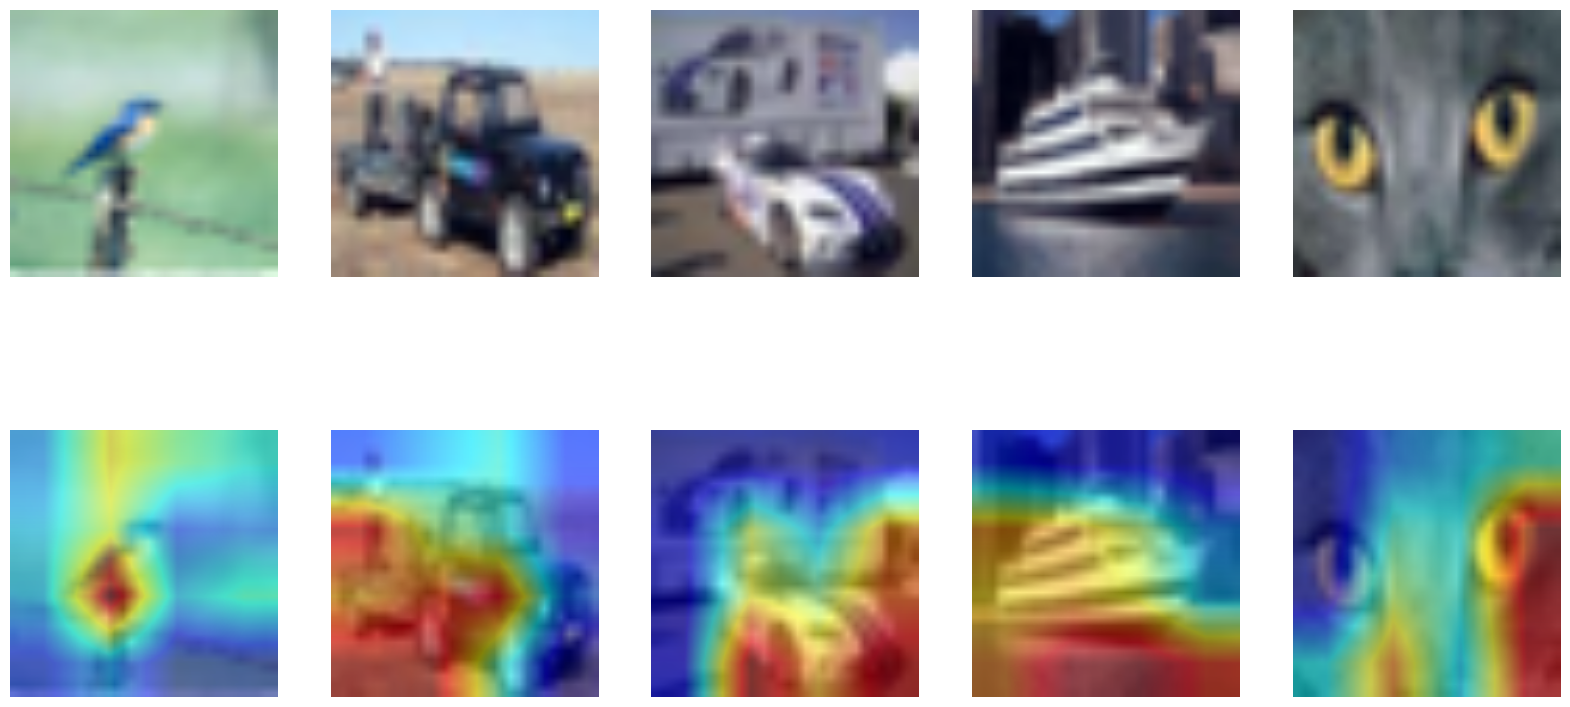

In [252]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):
    activation_map, _ = get_weighted_CAM(resnet18, torch.unsqueeze(sample_train_batch[i], 0), fc_params_student[smaple_labels_batch[i]])

    activation_map = activation_map.detach().numpy().astype(np.uint8)

    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)
    original_image = cv2.resize(original_image, (224, 224))

    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(activation_map)
    axes[1][i].axis('off')

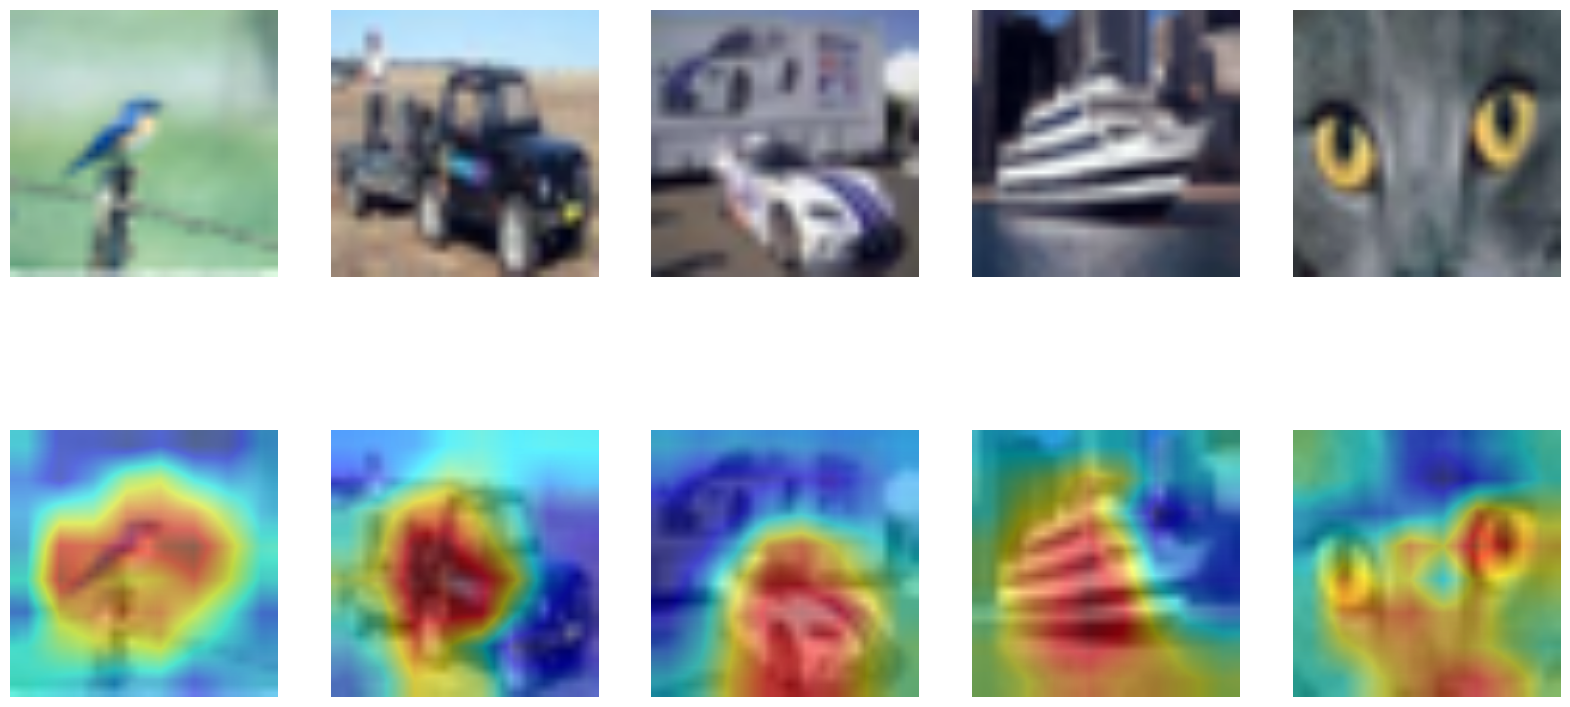

In [253]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for i in range(5):  
    activation_map, _ = get_weighted_CAM(wrn, torch.unsqueeze(sample_train_batch[i], 0), fc_params_teacher[smaple_labels_batch[i]], student=False)

    activation_map = activation_map.detach().numpy().astype(np.uint8)

    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)

    original_image = cv2.resize(original_image, (224, 224))

    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(activation_map)
    axes[1][i].axis('off')

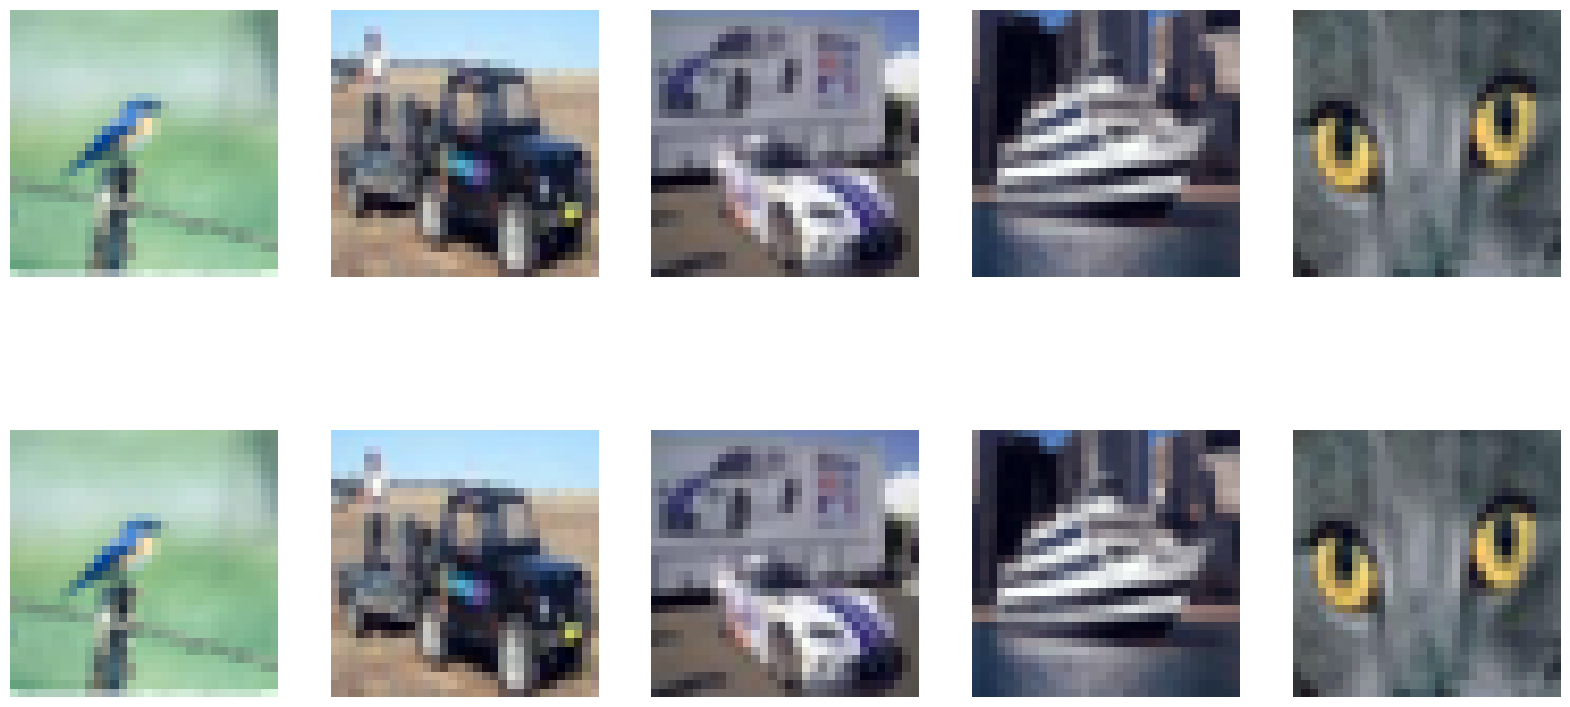

In [254]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
activation_maps_teacher = []
threshold = 0.6
occluded_images = []

for i in range(5):
    activation_map, _ = get_weighted_CAM(wrn, torch.unsqueeze(sample_train_batch[i], 0), fc_params_teacher[smaple_labels_batch[i]], student=False)
    activation_map = activation_map.detach().numpy().astype(np.float64)
    activation_map /= activation_map.max()
    activation_map = cv2.resize(activation_map, (32, 32))

    original_image = sample_train_batch[i].numpy().transpose(1, 2, 0)
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)
    original_image = original_image * 255
    original_image = original_image.astype(np.uint8)

    activation_map = np.ones((32, 32))
    occluded_image = original_image * np.stack((activation_map, activation_map, activation_map)).transpose(1, 2, 0)
    occluded_image -= np.min(occluded_image)
    occluded_image /= np.max(occluded_image)
    occluded_image *= 255
    occluded_image = occluded_image.astype(np.uint8)

    # print(occluded_image.shape)

    axes[0][i].imshow(original_image)
    axes[0][i].axis('off')
    axes[1][i].imshow(occluded_image)
    axes[1][i].axis('off')

    occluded_image -= np.min(occluded_image)
    occluded_image /= np.max(occluded_image)
    occluded_images.append(occluded_image.transpose(2, 0, 1))

occluded_images = torch.tensor(occluded_images).float()

In [255]:
# summary(resnet18, (3, 32, 32))
# summary(wrn, (3, 32, 32))
# summary(resnext, (3, 32, 32))

torch.Size([5, 3, 32, 32]) uint8
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
tensor([0, 0, 0, 0, 0]) tensor([2, 9, 1, 8, 3]) tensor([2, 9, 1, 8, 3])


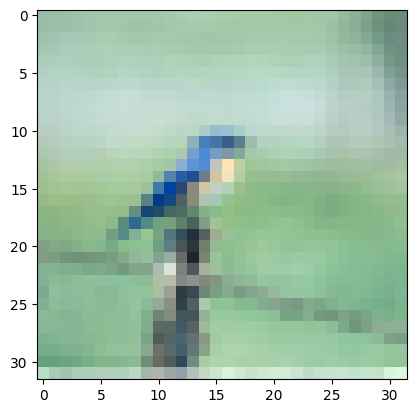

In [256]:
print(occluded_images.shape, occluded_image.dtype)

# samp = occluded_images[0]
# plt.imshow(samp.numpy().transpose(1, 2, 0).astype(np.uint8))

print(occluded_images[0].shape)
plt.imshow(occluded_images[0].numpy().transpose(1, 2, 0).astype(np.uint8))
train_transformer_2 = transforms.Compose([
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
occluded_images = train_transformer_2(occluded_images)
temp = train_transformer_2(occluded_images[0])
print(temp.shape)

wrn.eval()
true_prediction_probability = wrn(sample_train_batch[:5])
occluded_prediction_probability = wrn(occluded_images)
# occluded_prediction_probability = wrn(temp.unsqueeze(0))
print(torch.argmax(occluded_prediction_probability, dim=1), smaple_labels_batch[:5], torch.argmax(true_prediction_probability, dim=1))